## 2 Qubit State

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from itertools import product
from functools import reduce
import matplotlib.cm as cm

In [20]:
L = 2 # Number of qubits
d = 2**L # Dimension of Hilbert space

Define the Pauli Matrices:

In [44]:
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

In [62]:
m, p = np.linalg.eig(X).eigenvectors
mi, pi = np.linalg.eig(Y).eigenvectors
zero, one = np.linalg.eig(Z).eigenvectors

In [83]:
vs = np.array([np.kron(m, pi), np.kron(m, mi), np.kron(p, pi), np.kron(p, mi)])
vs

array([[ 0.5+0.j ,  0. -0.5j, -0.5+0.j ,  0. +0.5j],
       [ 0. -0.5j,  0.5+0.j ,  0. +0.5j, -0.5+0.j ],
       [ 0.5+0.j ,  0. -0.5j,  0.5+0.j ,  0. -0.5j],
       [ 0. -0.5j,  0.5+0.j ,  0. -0.5j,  0.5+0.j ]])

In [84]:
np.outer(vs[0], vs[0])

array([[ 0.25+0.j  ,  0.  -0.25j, -0.25+0.j  ,  0.  +0.25j],
       [ 0.  -0.25j, -0.25-0.j  ,  0.  +0.25j,  0.25+0.j  ],
       [-0.25+0.j  ,  0.  +0.25j,  0.25-0.j  , -0.  -0.25j],
       [ 0.  +0.25j,  0.25+0.j  , -0.  -0.25j, -0.25+0.j  ]])

In [85]:
outers = np.array([ np.outer(v.conj(), v) for v in vs])
np.sum(outers, axis=0)
# outers

array([[1.+0.00000000e+00j, 0.-1.38777878e-16j, 0.+0.00000000e+00j,
        0.+0.00000000e+00j],
       [0.+1.38777878e-16j, 1.+0.00000000e+00j, 0.+0.00000000e+00j,
        0.+0.00000000e+00j],
       [0.+0.00000000e+00j, 0.+0.00000000e+00j, 1.+0.00000000e+00j,
        0.-1.38777878e-16j],
       [0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+1.38777878e-16j,
        1.+0.00000000e+00j]])

Construct a test density matrix: L=2 GHZ state:
$$
| \psi \rangle = \frac{1}{\sqrt{2}} ( |00 \rangle + |11\rangle)
$$

$$
\rho = | \psi \rangle \langle \psi |
$$
todo graph on 3d bar plot

In [24]:
psi = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)])
rho = np.outer(psi, psi)

Text(0.5, 0, '$|\\rho_{jk}|$')

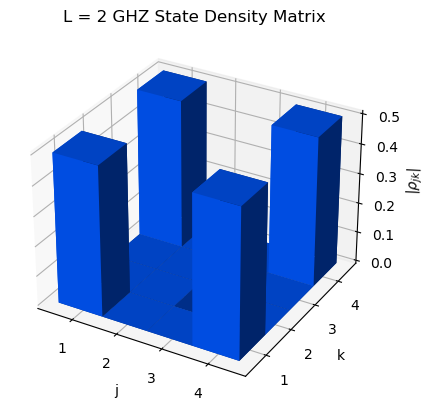

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

_x = np.arange(0.5, 4.5, 1)
_y = np.arange(0.5, 4.5, 1)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = np.abs(rho).ravel()
bottom = np.zeros_like(top)
width = depth = 1

# amplitudes = np.abs(rho)
phases = np.angle(rho)

# ax.bar3d(x, y, bottom, width, depth, top, shade=True)
ax.bar3d(x, y, bottom, width, depth, top, shade=True, color=plt.cm.hsv((3.9 + phases.flatten())/(2*np.pi)))

ax.set_title("L = 2 GHZ State Density Matrix")
ax.set_xlabel("j")
ax.set_ylabel("k")
ax.set_zlabel(r"$|\rho_{jk}|$")


todo add random complex phases and get colored visualization

In [26]:
# Define Pauli Matrices
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
paulis = np.array([X, Y, Z])

def get_projectors(measure_settings: np.ndarray):
    """
    Parameters:
        measure_settings: m by L array of 0, 1, or 2 determining Pauli basis
            where m is number of measurement settings
    Returns:
        Length md list of random Pauli basis projectors,
        i.e. returns list of P_k for eigenspace projectors P_k
    """
    eigvecs = np.array([ np.linalg.eig(sigma).eigenvectors for sigma in paulis ])
    # Number of qubits
    m = measure_settings.shape[0]
    d = 2**measure_settings.shape[1] # d = 2^L

    # Set of dxd projectors for each basis for each measurement setting
    P = np.zeros((m, d, d, d), dtype="complex128")

    for j, pauli_idx in enumerate(measure_settings):

        pauli_eigs_l = eigvecs[pauli_idx]

        # Get all combinations of 1 eigenvector from each pauli across L paulis
        eigs_sets = list(product(*pauli_eigs_l)) # 2^L total

        for k, set in enumerate(eigs_sets):
            # Tensor product all eigenvectors
            v_k = reduce(np.kron, set)
            # Form projector onto eigenspace
            proj_k = np.outer(np.conj(v_k), v_k)
            P[j, k, :, :] = proj_k

    return P

In [27]:
def sampling_operator(U: np.ndarray, Pk: np.ndarray):
    """
    Parameters:
        U: dxd density matrix
        Pk: m x d x d x d array of projection operators
    Returns:
        A(U) = [ [tr(UP_1), ...], ..., [..., tr(UP_md)] ]
    """
    return np.array([[
            np.real(np.trace(P @ U)) for P in P_setting ]
        for P_setting in Pk ])

In [28]:
N = 100 # Num. of measurement repeats
m = 11 # Num. of measurement settings
measures_test = np.random.randint(0, 3, size=(m, L))

In [29]:
proj_k = get_projectors(measures_test)

Generate some noisy measurements:

In [30]:
# Each measurement setting defines a new basis which is some multinomial distribution
probabilities = sampling_operator(rho, proj_k)
samples = np.array([ np.random.multinomial(N, basis_probs) for basis_probs in probabilities ])

# Normalize and flatten
Y = samples.flatten() / N

## Convex problem

$$
\min_X ||X||_{*} \quad \mathrm{s.t.} \: X \succcurlyeq 0, ||\mathcal{A}(X) - \mathcal{Y}||_2 ^2 \leq \varepsilon
$$

In [31]:
# np.linalg.norm(AU - Y)

In [32]:
# U = np.random.normal(rho, 2)
# U

In [33]:
# proj_flat = proj_k.reshape(proj_k.shape[0]*proj_k.shape[1], d, d)
# md = proj_k.shape[0]*proj_k.shape[1]

# AU = np.vstack([np.trace(proj_flat[i] @ U) - Y[i] for i in range(md)])
# np.linalg.norm(AU)
# AU

In [34]:
epsilon = 0.35
proj_flat = proj_k.reshape(proj_k.shape[0]*proj_k.shape[1], d, d)
md = proj_k.shape[0]*proj_k.shape[1]

X = cp.Variable((d, d), complex=True)

AX = cp.reshape(cp.vstack([cp.trace(proj_flat[i] @ X) for i in range(md)]), (md))
constraints = [X >> 0]

constraints += [cp.norm(AX - Y) <= epsilon]

prob = cp.Problem(cp.Minimize(cp.normNuc(X)),   
                  constraints)
prob.solve()

0.8899019076765944

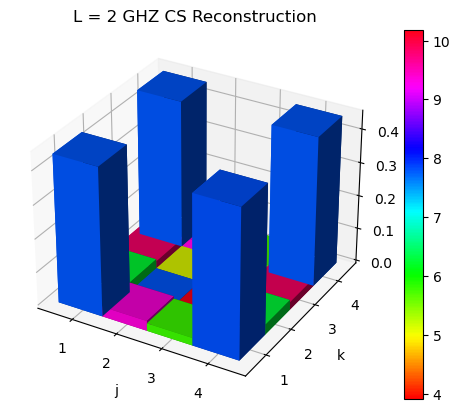

In [35]:
from matplotlib.colors import Normalize

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
_x = np.arange(0.5, 4.5, 1)
_y = np.arange(0.5, 4.5, 1)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

cs_sltn = X.value
amplitudes = np.abs(cs_sltn)
phases = np.angle(cs_sltn)

top = amplitudes.ravel()
bottom = np.zeros_like(top)
width = depth = 1


ax.bar3d(x, y, bottom, width, depth, top, shade=True, color=plt.cm.hsv((3.9 + phases.flatten())/(2*np.pi)))
ax.set_title("L = 2 GHZ CS Reconstruction")
ax.set_xlabel("j")
ax.set_ylabel("k")
ax.set_zlabel(r"$|\rho_{jk}|$")

fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(3.9, 3.9+2*np.pi), cmap=plt.cm.hsv))

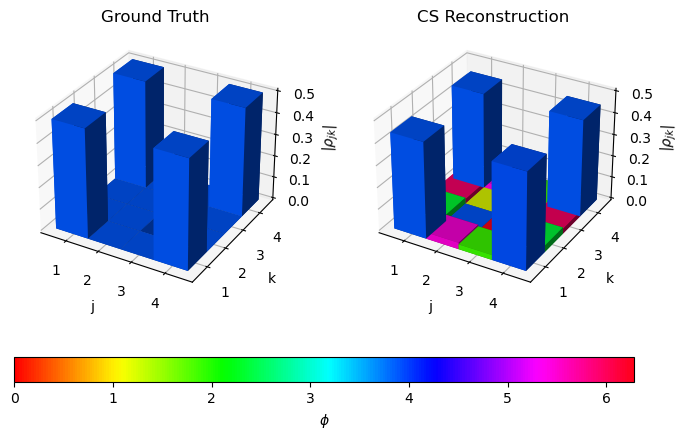

In [36]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

_x = np.arange(0.5, 4.5, 1)
_y = np.arange(0.5, 4.5, 1)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = np.abs(rho).ravel()
angle = np.angle(rho).ravel()

top_cs = np.abs(cs_sltn).ravel()
angle_cs = np.angle(cs_sltn).ravel()

bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True, color=plt.cm.hsv((3.9 + angle.flatten())/(2*np.pi)))
ax1.set_title("Ground Truth")
ax1.set_xlabel("j")
ax1.set_ylabel("k")
ax1.set_zlabel(r"$|\rho_{jk}|$")

ax2.bar3d(x, y, bottom, width, depth, top_cs, shade=True, color=plt.cm.hsv((3.9 + angle_cs.flatten())/(2*np.pi)))
ax2.set_title("CS Reconstruction")
ax2.set_zlim(0, 0.5)
ax2.set_xlabel("j")
ax2.set_ylabel("k")
ax2.set_zlabel(r"$|\rho_{jk}|$")

ticks = np.linspace(0, 2 * np.pi, num=5)

cb = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 2*np.pi, ), cmap=plt.cm.hsv), orientation="horizontal",
             location="bottom", ax=[ax1, ax2], aspect=25, label=r"$\phi$")
# # cb.set_ticks(ticks)
